## Example 2: Calculating absorption and emission spectra

In this example, we will use the Huang-Rhys parameters calculated in Example 1 to simulate the absorption and emission spectra of BPEA [9,10-Bis(phenylethynyl)anthracene]. 

We begin by importing the necessary functionality. The Franck-Condon spectra can be calculated using the 'Molecule' class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vibron.nwchem_utils import nwread, nwdushinsky
from vibron.utils import units
from vibron import Molecule

### Extracting DFT parameters

We first again extract the vibrational frequencies of the ground-state BPEA molecule and calculate the Huang-Rhys parameters associated with excitation to S$_1$.

In [2]:
vib_modes = nwread.read_frequencies('./nwchem_outs/S0_opt.out')
hr_parameters = nwdushinsky.huang_rhys('./nwchem_outs/S0_opt.out','./nwchem_outs/S1_opt.out')

We can then extract the excited state energy and create the Molecule

In [3]:
ex_energy = nwread.read_optenergy('./nwchem_outs/S1_opt.out') - nwread.read_optenergy('./nwchem_outs/S0_opt.out')

print(f'Excitation energy: {ex_energy:.2f} eV')

BPEA = Molecule(ex_energy = ex_energy, vib_modes=vib_modes, hr_parameters=hr_parameters)

Excitation energy: 2.33 eV


### Calculating gas phase spectrum

Currently, the spectra would comprise only a 'forest' of delta functions. Therefore, we will first introduce some degree of lifetime broadening and then calculate the spectra (the temperature is set to 300 K by default but can be set with BPEA.temp_K).  

No dipole moment was given. Returning a normalized spectrum.
No dipole moment was given. Returning a normalized spectrum.


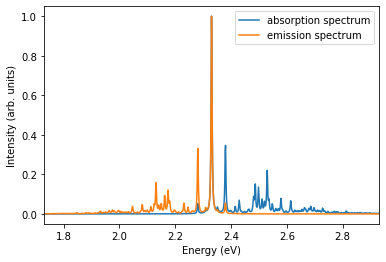

In [4]:
BPEA.gamma = 2e-3

abs_energy, absorption = BPEA.absorption_spectrum()
em_energy, emission = BPEA.emission_spectrum()

plt.plot(abs_energy,absorption, label = 'absorption spectrum')
plt.plot(em_energy,emission, label = 'emission spectrum')
plt.xlim(ex_energy-0.6,ex_energy+0.6)
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Energy (eV)')
plt.legend()

### Solution spectra

In solution, we should expect some degree of outer-sphere-like coupling with the solvent. We introduce it below and re-evaluate the spectrum. In doing so, we recover a more characteristic pseudo-single-mode spectra.

No dipole moment was given. Returning a normalized spectrum.
No dipole moment was given. Returning a normalized spectrum.


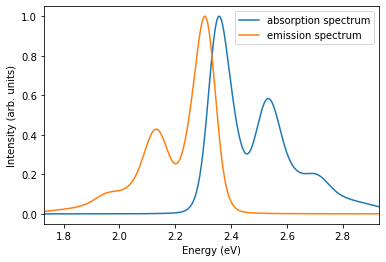

In [5]:
BPEA.lambda_o = 0.02

abs_energy, absorption = BPEA.absorption_spectrum()
em_energy, emission = BPEA.emission_spectrum()

plt.plot(abs_energy,absorption, label = 'absorption spectrum')
plt.plot(em_energy,emission, label = 'emission spectrum')
plt.xlim(ex_energy-0.6,ex_energy+0.6)
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Energy (eV)')
plt.legend()


We can also plot it as a function of the wavelength rather than the photon energy:

<ipython-input-6-b3c4f62a6488>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(units.eV2nm/abs_energy,absorption, label = 'absorption spectrum')
<ipython-input-6-b3c4f62a6488>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(units.eV2nm/em_energy,emission, label = 'emission spectrum')


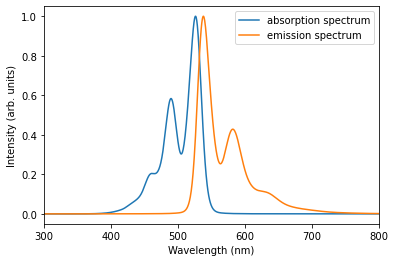

In [6]:
plt.plot(units.eV2nm/abs_energy,absorption, label = 'absorption spectrum')
plt.plot(units.eV2nm/em_energy,emission, label = 'emission spectrum')
plt.xlim(300,800)
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Wavelength (nm)')
plt.legend()

### Fluorescence lifetime
We can also calculate the fluorescence rate (or its inverse, the lifetime). They can both be determined after the transition dipole moment (in Debye) is supplied.

In [7]:
BPEA.gamma = 0
BPEA.dipole = nwread.read_transitiondipole('./nwchem_outs/S1_vertical.out')

fl_rate = BPEA.fluorescence_rate()

print(f"Fluorescence lifetime = {1e9/fl_rate:.2f} ns")

Fluorescence lifetime = 6.48 ns


## Beyond the 'Marcus' treatment of the solvent

By default, the outer-sphere coupling was treated within the Marcus (high-temperature, low-frequency) approach. We can instead take a more sophisticated approach and model it through an Ohmic spectral density: $J(\omega) = \lambda_o \frac{\omega}{\omega_c} e^{-\omega/\omega_c}$. To evaluate the corresponding spectrum, we will need to set the cut-off frequency and indicate that the environment is to be modelled through the Ohmic spectral density. 

First, we will extract the transition dipole moment from the NWChem calculation:

In [8]:
dipole = nwread.read_transitiondipole('./nwchem_outs/S1_vertical.out')


Below, we investigate how well the Marcus (low-frequency) approximation works depending on the cut-off frequency. We will use the example of the emission spectrum.

In [9]:
BPEA2 = Molecule(ex_energy = ex_energy, vib_modes=vib_modes, hr_parameters=hr_parameters)
BPEA2.lambda_o = 0.02
BPEA2.temp_K = 273
BPEA2.dipole = dipole

# Calculation with the Marcus approach:

em_energy, Marcus = BPEA2.emission_spectrum() # environment = 'Marcus' is the default setting

# Calculations with an Ohmic spectral density: 

cut_offs = [1e-2, 5e-2]
ohmic_spectra = []

for cutoff in cut_offs:
    
    BPEA2.w_cut = cutoff
    
    energy, spectr = BPEA2.emission_spectrum(environment = 'Ohmic')
    ohmic_spectra.append(spectr)

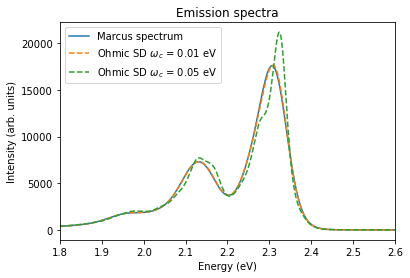

In [10]:
plt.plot(em_energy, Marcus, label = 'Marcus spectrum')

for (jk, spectrum) in enumerate(ohmic_spectra):
    
    label = 'Ohmic SD $\omega_c$ = ' + str(cut_offs[jk]) + ' eV'
    plt.plot(energy, spectrum, label = label ,linestyle='--')


plt.xlim(1.8,2.6)
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Energy (eV)')
plt.title('Emission spectra')
plt.legend()

Unsurprisingly, the two approaches agree only when $\omega_c \ll k_B T$ (here, $k_B T = 0.024$ eV).